In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from PIL import Image
import json
import os

# CSV 파일 읽기
foreground_background_file = 'ColorSchemes.csv'
object_file = 'ColorSchemes_Object.csv'
color_data = pd.read_csv(foreground_background_file)
object_data = pd.read_csv(object_file)

# RGB 문자열을 파싱하여 정수형 배열로 변환
def parse_rgb_string(rgb_string):
    return list(map(int, rgb_string.strip("RGB()").split(", ")))

# 전경/배경 데이터에서 색상과 가중치를 추출
def extract_color_and_weight(df_row, prefix):
    colors = []
    weights = []
    for i in range(1, 6):
        color = parse_rgb_string(df_row[f"{prefix} Color {i} (RGB)"])
        weight = df_row[f"{prefix} Weight {i}"]
        colors.append(color)
        weights.append(weight)
    return np.array(colors), np.array(weights)

# 개체 데이터에서 색상과 가중치를 추출
def extract_object_color_and_weight(df_row, obj_num):
    colors = []
    weights = []
    for i in range(1, 6):
        color_key = f"Object{obj_num} Color {i} (RGB)"
        weight_key = f"Object{obj_num} Weight {i}"
        if pd.isna(df_row[color_key]) or pd.isna(df_row[weight_key]):
            continue
        color = parse_rgb_string(df_row[color_key])
        weight = df_row[weight_key]
        colors.append(color)
        weights.append(weight)
    
    size_weight = df_row.get(f"Object{obj_num}_Size_Weight", np.nan)
    if isinstance(size_weight, str) and '%' in size_weight:
        size_weight = float(size_weight.strip('%')) / 100
    elif not pd.isna(size_weight):
        size_weight /= 100
    
    return np.array(colors), np.array(weights), size_weight

# CHD 계산 함수
def modified_hausdorff_distance(cluster1, cluster2):
    distances = cdist(cluster1, cluster2, 'euclidean')
    mhd = np.mean(np.min(distances, axis=1))
    return mhd

def cluster_based_hausdorff_distance(palette1, palette2, weights1=None, weights2=None, k=2):
    if weights1 is not None:
        palette1 = np.repeat(palette1, (weights1 * 100).astype(int), axis=0)
    if weights2 is not None:
        palette2 = np.repeat(palette2, (weights2 * 100).astype(int), axis=0)
    
    kmeans1 = KMeans(n_clusters=k, random_state=0).fit(palette1)
    clusters1 = [palette1[kmeans1.labels_ == i] for i in range(k)]
    kmeans2 = KMeans(n_clusters=k, random_state=0).fit(palette2)
    clusters2 = [palette2[kmeans2.labels_ == i] for i in range(k)]
    
    mhd_values = []
    for cluster1 in clusters1:
        mhd_cluster = [modified_hausdorff_distance(cluster1, cluster2) for cluster2 in clusters2]
        mhd_values.append(np.min(mhd_cluster))
    
    return max(mhd_values)

# 색상 스키마 시각화 함수
def visualize_palette(palette, weights, title="Color Palette"):
    total_weight = np.sum(weights)
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    current_x = 0
    for color, weight in zip(palette, weights):
        width = weight / total_weight
        ax.add_patch(plt.Rectangle((current_x, 0), width, 1, color=np.array(color) / 255.0))
        current_x += width
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title(title)
    plt.show()

# 전경/배경 데이터 비교
def compare_foreground_background(target_index):
    target_row = color_data[color_data['Image Index'] == target_index].iloc[0]
    selected_fg_colors, selected_fg_weights = extract_color_and_weight(target_row, "Foreground")
    selected_bg_colors, selected_bg_weights = extract_color_and_weight(target_row, "Background")
    
    min_fg_chd, min_bg_chd = float('inf'), float('inf')
    min_fg_image, min_bg_image = None, None
    min_fg_palette, min_bg_palette = None, None

    for _, row in color_data.iterrows():
        if row['Image Index'] == target_index:
            continue
        
        fg_colors, fg_weights = extract_color_and_weight(row, "Foreground")
        bg_colors, bg_weights = extract_color_and_weight(row, "Background")
        
        fg_chd = cluster_based_hausdorff_distance(selected_fg_colors, fg_colors, selected_fg_weights, fg_weights)
        if fg_chd < min_fg_chd:
            min_fg_chd = fg_chd
            min_fg_image = row['Image Index']
            min_fg_palette = fg_colors
        
        bg_chd = cluster_based_hausdorff_distance(selected_bg_colors, bg_colors, selected_bg_weights, bg_weights)
        if bg_chd < min_bg_chd:
            min_bg_chd = bg_chd
            min_bg_image = row['Image Index']
            min_bg_palette = bg_colors
    
    return min_fg_image, min_fg_palette, min_fg_chd, min_bg_image, min_bg_palette, min_bg_chd

# 개체 데이터 비교
def compare_objects(target_index):
    target_row = object_data[object_data['Image Index'] == target_index].iloc[0]
    target_object_data = [
        extract_object_color_and_weight(target_row, obj_num)
        for obj_num in range(1, 6)
        if not pd.isna(target_row[f"Object{obj_num}_Size_Weight"])
    ]
    
    min_chd, most_similar_image = float('inf'), None
    most_similar_object_schemes = None

    for _, row in object_data.iterrows():
        if row['Image Index'] == target_index:
            continue
        
        comparison_object_data = [
            extract_object_color_and_weight(row, obj_num)
            for obj_num in range(1, 6)
            if not pd.isna(row[f"Object{obj_num}_Size_Weight"])
        ]
        
        cost_matrix = np.array([
            [cluster_based_hausdorff_distance(obj1_colors, obj2_colors, obj1_weights, obj2_weights)
             for obj2_colors, obj2_weights, _ in comparison_object_data]
            for obj1_colors, obj1_weights, _ in target_object_data
        ])
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        
        total_chd = sum(cost_matrix[row_ind[i], col_ind[i]] * target_object_data[i][2] for i in range(len(row_ind)))
        total_weight = sum(target_object_data[i][2] for i in range(len(row_ind)))
        weighted_chd = total_chd / total_weight if total_weight else float('inf')
        
        if weighted_chd < min_chd:
            min_chd = weighted_chd
            most_similar_image = row['Image Index']
            most_similar_object_schemes = [(comparison_object_data[i][0], comparison_object_data[i][1]) for i in col_ind]
    
    return most_similar_image, most_similar_object_schemes, min_chd

# 기준 이미지 번호를 입력 받아 전경, 배경, 개체별 가장 유사한 이미지 찾기
def find_most_similar_images(target_index):
    fg_image, fg_palette, fg_chd, bg_image, bg_palette, bg_chd = compare_foreground_background(target_index)
    obj_image, obj_palettes, obj_chd = compare_objects(target_index)
    
    # 결과 출력
    print(f"Target Image: {target_index}")
    
    print(f"Most Similar Foreground Image: {fg_image}, CHD: {fg_chd}")
    display_image(fg_image)
    visualize_palette(fg_palette, fg_palette, title="Most Similar Foreground Palette")
    
    print(f"Most Similar Background Image: {bg_image}, CHD: {bg_chd}")
    display_image(bg_image)
    visualize_palette(bg_palette, bg_palette, title="Most Similar Background Palette")
    
    print(f"Most Similar Objects Image: {obj_image}, CHD: {obj_chd}")
    display_image(obj_image)
    for i, (colors, weights) in enumerate(obj_palettes, 1):
        visualize_palette(colors, weights, title=f"Most Similar Object {i} Palette")
    
    return {
        "Foreground": {"Most Similar Image": fg_image, "CHD": fg_chd},
        "Background": {"Most Similar Image": bg_image, "CHD": bg_chd},
        "Objects": {"Most Similar Image": obj_image, "CHD": obj_chd}
    }

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os

# (이전의 모든 코드 유지)

# 이미지 파일 로드 및 표시 함수
def display_image(image_index):
    possible_extensions = ['.png', '.jpg']
    img_path = None
    for ext in possible_extensions:
        path = f"x_images/img{image_index}{ext}"
        if os.path.exists(path):
            img_path = path
            break
    
    if img_path:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {image_index}")
        plt.show()
    else:
        print(f"No image file found for index {image_index} in 'images/' directory.")

# 기준 이미지 번호를 입력 받아 전경, 배경, 개체별 가장 유사한 이미지 찾기
def find_most_similar_images(target_index):
    fg_image, fg_palette, fg_chd, bg_image, bg_palette, bg_chd = compare_foreground_background(target_index)
    obj_image, obj_palettes, obj_chd = compare_objects(target_index)
    
    # 결과 출력
    #print(f"\nTarget Image: {target_index}")
    display_image(target_index)
    
    #print("\nTarget Foreground Palette:")
    target_fg_colors, target_fg_weights = extract_color_and_weight(color_data[color_data['Image Index'] == target_index].iloc[0], "Foreground")
    #visualize_palette(target_fg_colors, target_fg_weights, title="Target Foreground Palette")
    
    #print("\nTarget Background Palette:")
    target_bg_colors, target_bg_weights = extract_color_and_weight(color_data[color_data['Image Index'] == target_index].iloc[0], "Background")
    #visualize_palette(target_bg_colors, target_bg_weights, title="Target Background Palette")
    
    #print("\nTarget Object Palettes:")
    target_object_data = [
        extract_object_color_and_weight(object_data[object_data['Image Index'] == target_index].iloc[0], obj_num)
        for obj_num in range(1, 6)
        if not pd.isna(object_data[object_data['Image Index'] == target_index].iloc[0][f"Object{obj_num}_Size_Weight"])
    ]
    '''
    for i, (colors, weights, size_weight) in enumerate(target_object_data, 1):
        visualize_palette(colors, weights, title=f"Target Object {i} Palette")
    '''
    print(f"\nMost Similar Foreground Image: {fg_image}, CHD: {fg_chd}")
    display_image(fg_image)
    visualize_palette(fg_palette, np.ones_like(fg_palette[:, 0]), title="Most Similar Foreground Palette")
    
    print(f"\nMost Similar Background Image: {bg_image}, CHD: {bg_chd}")
    display_image(bg_image)
    visualize_palette(bg_palette, np.ones_like(bg_palette[:, 0]), title="Most Similar Background Palette")
    
    print(f"\nMost Similar Objects Image: {obj_image}, CHD: {obj_chd}")
    display_image(obj_image)
    for i, (colors, weights) in enumerate(obj_palettes, 1):
        visualize_palette(colors, weights, title=f"Most Similar Object {i} Palette")
    
    return {
        "Foreground": {"Most Similar Image": fg_image, "CHD": fg_chd},
        "Background": {"Most Similar Image": bg_image, "CHD": bg_chd},
        "Objects": {"Most Similar Image": obj_image, "CHD": obj_chd}
    }

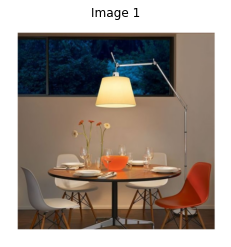


Most Similar Foreground Image: 4, CHD: 34.72621296345071


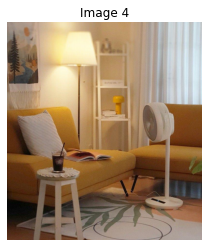

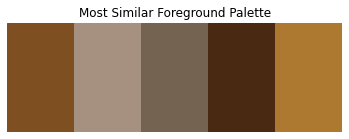


Most Similar Background Image: 16, CHD: 42.54741208581611


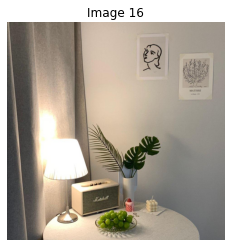

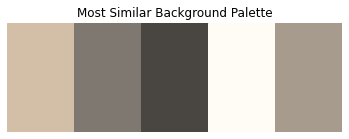


Most Similar Objects Image: 27, CHD: 32.591044997487444


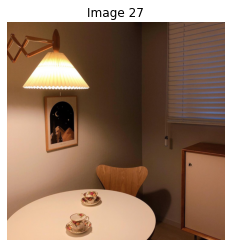

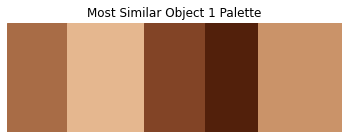

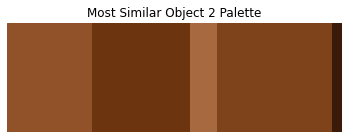

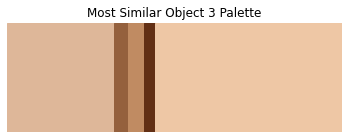

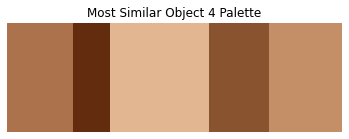

{
    "Foreground": {
        "Most Similar Image": 4,
        "CHD": 34.72621296345071
    },
    "Background": {
        "Most Similar Image": 16,
        "CHD": 42.54741208581611
    },
    "Objects": {
        "Most Similar Image": 27,
        "CHD": 32.591044997487444
    }
}


In [11]:
# 비교할 기준 이미지 번호 입력 받기
target_image_index = int(input("비교할 기준 이미지 번호를 입력하세요 (예: 1): "))
similar_images_result = find_most_similar_images(target_image_index)
print(json.dumps(similar_images_result, indent=4))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from PIL import Image
import os
import json

# CSV 파일 읽기
foreground_background_file = 'ColorScheme_csv_3.csv'
object_file = 'ColorScheme_Object_3.csv'
color_data = pd.read_csv(foreground_background_file)
object_data = pd.read_csv(object_file)

# RGB 문자열을 파싱하여 정수형 배열로 변환
def parse_rgb_string(rgb_string):
    return list(map(int, rgb_string.strip("RGB()").split(", ")))

# 전경/배경 데이터에서 색상과 가중치를 추출
def extract_color_and_weight(df_row, prefix):
    colors, weights = [], []
    for i in range(1, 6):
        color = parse_rgb_string(df_row[f"{prefix} Color {i} (RGB)"])
        weight = df_row[f"{prefix} Weight {i}"]
        colors.append(color)
        weights.append(weight)
    return np.array(colors), np.array(weights)

# 개체 데이터에서 색상과 가중치를 추출
def extract_object_color_and_weight(df_row, obj_num):
    colors, weights = [], []
    for i in range(1, 6):
        color_key, weight_key = f"Object{obj_num} Color {i} (RGB)", f"Object{obj_num} Weight {i}"
        if pd.isna(df_row[color_key]) or pd.isna(df_row[weight_key]):
            continue
        colors.append(parse_rgb_string(df_row[color_key]))
        weights.append(df_row[weight_key])
    
    size_weight = df_row.get(f"Object{obj_num}_Size_Weight", np.nan)
    if isinstance(size_weight, str) and '%' in size_weight:
        size_weight = float(size_weight.strip('%')) / 100
    elif not pd.isna(size_weight):
        size_weight /= 100
    return np.array(colors), np.array(weights), size_weight

# CHD 계산 함수
def modified_hausdorff_distance(cluster1, cluster2):
    distances = cdist(cluster1, cluster2, 'euclidean')
    return np.mean(np.min(distances, axis=1))

def cluster_based_hausdorff_distance(palette1, palette2, weights1=None, weights2=None, k=2):
    if weights1 is not None:
        palette1 = np.repeat(palette1, (weights1 * 100).astype(int), axis=0)
    if weights2 is not None:
        palette2 = np.repeat(palette2, (weights2 * 100).astype(int), axis=0)
    
    kmeans1, kmeans2 = KMeans(n_clusters=k, random_state=0).fit(palette1), KMeans(n_clusters=k, random_state=0).fit(palette2)
    clusters1, clusters2 = [palette1[kmeans1.labels_ == i] for i in range(k)], [palette2[kmeans2.labels_ == i] for i in range(k)]
    
    mhd_values = [min(modified_hausdorff_distance(cluster1, cluster2) for cluster2 in clusters2) for cluster1 in clusters1]
    return max(mhd_values)

# 색상 스키마 시각화 함수
def visualize_palette(palette, weights, title="Color Palette"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    total_weight, current_x = np.sum(weights), 0
    for color, weight in zip(palette, weights):
        width = weight / total_weight
        ax.add_patch(plt.Rectangle((current_x, 0), width, 1, color=np.array(color) / 255.0))
        current_x += width
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title(title)
    plt.show()

# 이미지 출력 함수 (Image Name과 폴더 내부 파일 이름 비교)
def display_image(image_name, title="Image"):
    img_path = os.path.join('images', image_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
        plt.show()
    else:
        print(f"Image '{image_name}' not found in the 'images' directory.")

# 전경/배경 유사 이미지 비교
def compare_foreground_background(target_index):
    target_row = color_data[color_data['Image Index'] == target_index].iloc[0]
    target_fg_colors, target_fg_weights = extract_color_and_weight(target_row, "Foreground")
    target_bg_colors, target_bg_weights = extract_color_and_weight(target_row, "Background")
    min_fg_chd, min_bg_chd = float('inf'), float('inf')
    most_similar_fg_img, most_similar_bg_img = None, None
    for _, row in color_data.iterrows():
        if row['Image Index'] == target_index:
            continue
        fg_colors, fg_weights = extract_color_and_weight(row, "Foreground")
        bg_colors, bg_weights = extract_color_and_weight(row, "Background")
        fg_chd = cluster_based_hausdorff_distance(target_fg_colors, fg_colors, target_fg_weights, fg_weights)
        if fg_chd < min_fg_chd:
            min_fg_chd, most_similar_fg_img = fg_chd, row['Image Name']
        bg_chd = cluster_based_hausdorff_distance(target_bg_colors, bg_colors, target_bg_weights, bg_weights)
        if bg_chd < min_bg_chd:
            min_bg_chd, most_similar_bg_img = bg_chd, row['Image Name']
    return most_similar_fg_img, min_fg_chd, most_similar_bg_img, min_bg_chd

# 개체 유사 이미지 비교
def compare_objects(target_index):
    target_row = object_data[object_data['Image Index'] == target_index].iloc[0]
    target_object_data = [extract_object_color_and_weight(target_row, i) for i in range(1, 6)
                          if not pd.isna(target_row[f"Object{i}_Size_Weight"])]
    min_chd, most_similar_obj_img = float('inf'), None
    for _, row in object_data.iterrows():
        if row['Image Index'] == target_index:
            continue
        comparison_object_data = [extract_object_color_and_weight(row, i) for i in range(1, 6)
                                  if not pd.isna(row[f"Object{i}_Size_Weight"])]
        cost_matrix = np.array([[cluster_based_hausdorff_distance(obj1_colors, obj2_colors, obj1_weights, obj2_weights)
                                 for obj2_colors, obj2_weights, _ in comparison_object_data]
                                for obj1_colors, obj1_weights, _ in target_object_data])
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total_chd = sum(cost_matrix[row_ind[i], col_ind[i]] * target_object_data[i][2] for i in range(len(row_ind)))
        weighted_chd = total_chd / sum(target_object_data[i][2] for i in range(len(row_ind)))
        if weighted_chd < min_chd:
            min_chd, most_similar_obj_img = weighted_chd, row['Image Name']
    return most_similar_obj_img, min_chd

# 비교할 기준 이미지 번호를 입력받아 전경, 배경, 개체별 가장 유사한 이미지 찾기
def find_most_similar_images(target_index):
    target_row = color_data[color_data['Image Index'] == target_index].iloc[0]
    target_image_name = target_row["Image Name"]
    display_image(target_image_name, title="Target Image")
    
    fg_img, fg_chd, bg_img, bg_chd = compare_foreground_background(target_index)
    obj_img, obj_chd = compare_objects(target_index)
    
    print(f"\nMost Similar Foreground Image: {fg_img}, CHD: {fg_chd}")
    display_image(fg_img, title="Most Similar Foreground Image")
    
    print(f"\nMost Similar Background Image: {bg_img}, CHD: {bg_chd}")
    display_image(bg_img, title="Most Similar Background Image")
    
    print(f"\nMost Similar Objects Image: {obj_img}, CHD: {obj_chd}")
    display_image(obj_img, title="Most Similar Object Image")
    
    return {
        "Foreground": {"Most Similar Image": fg_img, "CHD": fg_chd},
        "Background": {"Most Similar Image": bg_img, "CHD": bg_chd},
        "Objects": {"Most Similar Image": obj_img, "CHD": obj_chd}
    }

# 가중 유클리드 거리 계산 함수 추가
def weighted_euclidean_distance(point1, point2, weights):
    """
    Calculate the weighted Euclidean distance between two points with given weights.
    """
    return np.sqrt(sum(weights[i] * (point1[i] - point2[i]) ** 2 for i in range(len(point1))))

# 최종 유사 이미지 선택 함수
def find_closest_image_by_chd(target_chd_values, similar_images, weights=[0.5, 0.3, 0.2]):
    """
    Find the closest image based on foreground, background, and object CHD values.
    
    Parameters:
    - target_chd_values (list): CHD values of the target image in the form [fg_chd, bg_chd, obj_chd]
    - similar_images (dict): Dictionary with image indices and their respective CHD values.
                             Format: {image_index: {'Foreground CHD': fg_chd, 'Background CHD': bg_chd, 'Object CHD': obj_chd}}
    - weights (list): Weights for each CHD component [foreground weight, background weight, object weight]
    
    Returns:
    - closest_image: The index of the image with the smallest weighted Euclidean distance to the target.
    - min_distance: The computed minimum weighted Euclidean distance.
    """
    reference_point = np.array(target_chd_values)
    min_distance = float('inf')
    closest_image = None

    for image, chd_values in similar_images.items():
        chd_point = np.array([
            chd_values['Foreground CHD'],
            chd_values['Background CHD'],
            chd_values['Object CHD']
        ])
        
        # 가중 유클리드 거리 계산
        distance = weighted_euclidean_distance(reference_point, chd_point, weights)
        
        if distance < min_distance:
            min_distance = distance
            closest_image = image

    return closest_image, min_distance


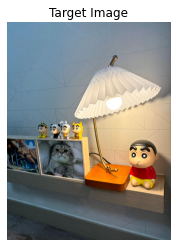


Most Similar Foreground Image: L_82.jpg, CHD: 34.84732665507312


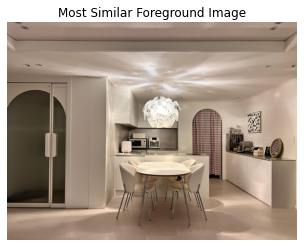


Most Similar Background Image: L_62.jpg, CHD: 36.86654353275398


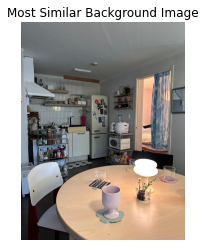


Most Similar Objects Image: L_128.jpg, CHD: 26.217295870213018


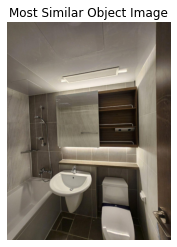

{
    "Foreground": {
        "Most Similar Image": "L_82.jpg",
        "CHD": 34.84732665507312
    },
    "Background": {
        "Most Similar Image": "L_62.jpg",
        "CHD": 36.86654353275398
    },
    "Objects": {
        "Most Similar Image": "L_128.jpg",
        "CHD": 26.217295870213018
    }
}


In [2]:
# 기준 이미지 번호 입력
target_image_index = int(input("비교할 기준 이미지 번호를 입력하세요: "))
similar_images_result = find_most_similar_images(target_image_index)
print(json.dumps(similar_images_result, indent=4))


Target Image and Palettes


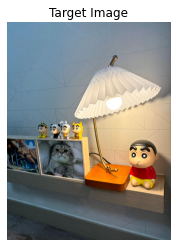

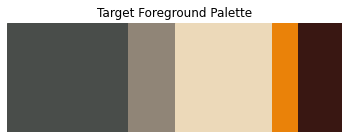

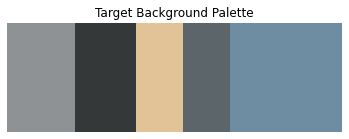

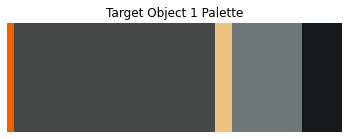

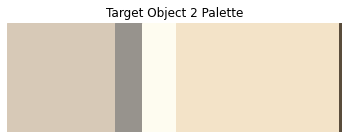

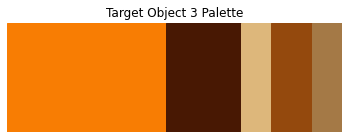

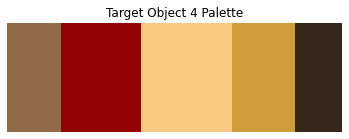

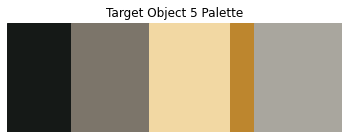


Final Closest Image based on CHD values: L_62.jpg, Weighted Distance: 23.885243003275


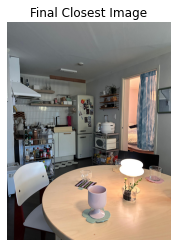

{
    "Foreground": {
        "Most Similar Image": "L_82.jpg",
        "CHD": 34.84732665507312
    },
    "Background": {
        "Most Similar Image": "L_62.jpg",
        "CHD": 36.86654353275398
    },
    "Objects": {
        "Most Similar Image": "L_128.jpg",
        "CHD": 26.217295870213018
    },
    "Final Closest Image": "L_62.jpg",
    "Weighted Distance": 23.885243003275
}


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from PIL import Image
import os
import json

# CSV 파일 읽기
foreground_background_file = 'ColorScheme_csv_3.csv'
object_file = 'ColorScheme_Object_3.csv'
color_data = pd.read_csv(foreground_background_file)
object_data = pd.read_csv(object_file)

# RGB 문자열을 파싱하여 정수형 배열로 변환
def parse_rgb_string(rgb_string):
    return list(map(int, rgb_string.strip("RGB()").split(", ")))

# 전경/배경 데이터에서 색상과 가중치를 추출
def extract_color_and_weight(df_row, prefix):
    colors, weights = [], []
    for i in range(1, 6):
        color = parse_rgb_string(df_row[f"{prefix} Color {i} (RGB)"])
        weight = df_row[f"{prefix} Weight {i}"]
        colors.append(color)
        weights.append(weight)
    return np.array(colors), np.array(weights)

# 개체 데이터에서 색상과 가중치를 추출
def extract_object_color_and_weight(df_row, obj_num):
    colors, weights = [], []
    for i in range(1, 6):
        color_key, weight_key = f"Object{obj_num} Color {i} (RGB)", f"Object{obj_num} Weight {i}"
        if pd.isna(df_row[color_key]) or pd.isna(df_row[weight_key]):
            continue
        colors.append(parse_rgb_string(df_row[color_key]))
        weights.append(df_row[weight_key])
    
    size_weight = df_row.get(f"Object{obj_num}_Size_Weight", np.nan)
    if isinstance(size_weight, str) and '%' in size_weight:
        size_weight = float(size_weight.strip('%')) / 100
    elif not pd.isna(size_weight):
        size_weight /= 100
    return np.array(colors), np.array(weights), size_weight

# 전경/배경 유사 이미지 비교
def compare_foreground_background(target_index):
    target_row = color_data[color_data['Image Index'] == target_index].iloc[0]
    target_fg_colors, target_fg_weights = extract_color_and_weight(target_row, "Foreground")
    target_bg_colors, target_bg_weights = extract_color_and_weight(target_row, "Background")
    min_fg_chd, min_bg_chd = float('inf'), float('inf')
    most_similar_fg_img, most_similar_bg_img = None, None
    for _, row in color_data.iterrows():
        if row['Image Index'] == target_index:
            continue
        fg_colors, fg_weights = extract_color_and_weight(row, "Foreground")
        bg_colors, bg_weights = extract_color_and_weight(row, "Background")
        fg_chd = cluster_based_hausdorff_distance(target_fg_colors, fg_colors, target_fg_weights, fg_weights)
        if fg_chd < min_fg_chd:
            min_fg_chd, most_similar_fg_img = fg_chd, row['Image Name']
        bg_chd = cluster_based_hausdorff_distance(target_bg_colors, bg_colors, target_bg_weights, bg_weights)
        if bg_chd < min_bg_chd:
            min_bg_chd, most_similar_bg_img = bg_chd, row['Image Name']
    return most_similar_fg_img, min_fg_chd, most_similar_bg_img, min_bg_chd

# 개체 유사 이미지 비교
def compare_objects(target_index):
    target_row = object_data[object_data['Image Index'] == target_index].iloc[0]
    target_object_data = [extract_object_color_and_weight(target_row, i) for i in range(1, 6)
                          if not pd.isna(target_row[f"Object{i}_Size_Weight"])]
    min_chd, most_similar_obj_img = float('inf'), None
    for _, row in object_data.iterrows():
        if row['Image Index'] == target_index:
            continue
        comparison_object_data = [extract_object_color_and_weight(row, i) for i in range(1, 6)
                                  if not pd.isna(row[f"Object{i}_Size_Weight"])]
        cost_matrix = np.array([[cluster_based_hausdorff_distance(obj1_colors, obj2_colors, obj1_weights, obj2_weights)
                                 for obj2_colors, obj2_weights, _ in comparison_object_data]
                                for obj1_colors, obj1_weights, _ in target_object_data])
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        total_chd = sum(cost_matrix[row_ind[i], col_ind[i]] * target_object_data[i][2] for i in range(len(row_ind)))
        weighted_chd = total_chd / sum(target_object_data[i][2] for i in range(len(row_ind)))
        if weighted_chd < min_chd:
            min_chd, most_similar_obj_img = weighted_chd, row['Image Name']
    return most_similar_obj_img, min_chd

# CHD 계산 함수
def modified_hausdorff_distance(cluster1, cluster2):
    distances = cdist(cluster1, cluster2, 'euclidean')
    return np.mean(np.min(distances, axis=1))

def cluster_based_hausdorff_distance(palette1, palette2, weights1=None, weights2=None, k=2):
    if weights1 is not None:
        palette1 = np.repeat(palette1, (weights1 * 100).astype(int), axis=0)
    if weights2 is not None:
        palette2 = np.repeat(palette2, (weights2 * 100).astype(int), axis=0)
    
    kmeans1, kmeans2 = KMeans(n_clusters=k, random_state=0).fit(palette1), KMeans(n_clusters=k, random_state=0).fit(palette2)
    clusters1, clusters2 = [palette1[kmeans1.labels_ == i] for i in range(k)], [palette2[kmeans2.labels_ == i] for i in range(k)]
    
    mhd_values = [min(modified_hausdorff_distance(cluster1, cluster2) for cluster2 in clusters2) for cluster1 in clusters1]
    return max(mhd_values)

# 색상 스키마 시각화 함수
def visualize_palette(palette, weights, title="Color Palette"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 2))
    total_weight, current_x = np.sum(weights), 0
    for color, weight in zip(palette, weights):
        width = weight / total_weight
        ax.add_patch(plt.Rectangle((current_x, 0), width, 1, color=np.array(color) / 255.0))
        current_x += width
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    ax.set_title(title)
    plt.show()

# 이미지 출력 함수
def display_image(image_name, title="Image"):
    img_path = os.path.join('images', image_name)
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(title)
        plt.show()
    else:
        print(f"Image '{image_name}' not found in the 'images' directory.")

# 기준 이미지의 전경, 배경, 개체 팔레트를 시각화
def display_target_palettes(target_index):
    target_row = color_data[color_data['Image Index'] == target_index].iloc[0]
    target_fg_colors, target_fg_weights = extract_color_and_weight(target_row, "Foreground")
    target_bg_colors, target_bg_weights = extract_color_and_weight(target_row, "Background")
    target_object_data = [extract_object_color_and_weight(object_data[object_data['Image Index'] == target_index].iloc[0], i)
                          for i in range(1, 6) if not pd.isna(object_data[object_data['Image Index'] == target_index].iloc[0][f"Object{i}_Size_Weight"])]
    
    # 전경, 배경, 개체별 팔레트 시각화
    visualize_palette(target_fg_colors, target_fg_weights, title="Target Foreground Palette")
    visualize_palette(target_bg_colors, target_bg_weights, title="Target Background Palette")
    for i, (colors, weights, _) in enumerate(target_object_data, 1):
        visualize_palette(colors, weights, title=f"Target Object {i} Palette")

# 기준 이미지의 전경, 배경, 개체별 가장 유사한 이미지를 찾고 최종 유사 이미지를 선택하는 함수
def find_most_similar_and_final_image(target_index):
    # 기본 전경, 배경, 개체 유사 이미지 찾기
    fg_img, fg_chd, bg_img, bg_chd = compare_foreground_background(target_index)
    obj_img, obj_chd = compare_objects(target_index)

    # 유사 이미지 정보 구성
    similar_images = {
        fg_img: {"Foreground CHD": fg_chd, "Background CHD": 0, "Object CHD": 0},
        bg_img: {"Foreground CHD": 0, "Background CHD": bg_chd, "Object CHD": 0},
        obj_img: {"Foreground CHD": 0, "Background CHD": 0, "Object CHD": obj_chd}
    }

    # 각 CHD 값을 사용하여 최종 유사 이미지 선택
    target_chd_values = [fg_chd, bg_chd, obj_chd]
    closest_image, min_distance = find_closest_image_by_chd(
        target_chd_values, similar_images, weights=[0.3, 0.3, 0.3]
    )

    # 기준 이미지 시각화
    target_row = color_data[color_data['Image Index'] == target_index].iloc[0]
    target_image_name = target_row["Image Name"]
    print("\nTarget Image and Palettes")
    display_image(target_image_name, title="Target Image")
    display_target_palettes(target_index)

    # 유사 이미지 출력
    #print(f"\nMost Similar Foreground Image: {fg_img}, CHD: {fg_chd}")
    #display_image(fg_img, title="Most Similar Foreground Image")
    
    #print(f"\nMost Similar Background Image: {bg_img}, CHD: {bg_chd}")
    #display_image(bg_img, title="Most Similar Background Image")
    
    #print(f"\nMost Similar Objects Image: {obj_img}, CHD: {obj_chd}")
    #display_image(obj_img, title="Most Similar Object Image")

    print(f"\nFinal Closest Image based on CHD values: {closest_image}, Weighted Distance: {min_distance}")
    display_image(closest_image, title="Final Closest Image")

    return {
        "Foreground": {"Most Similar Image": fg_img, "CHD": fg_chd},
        "Background": {"Most Similar Image": bg_img, "CHD": bg_chd},
        "Objects": {"Most Similar Image": obj_img, "CHD": obj_chd},
        "Final Closest Image": closest_image,
        "Weighted Distance": min_distance
    }

# 기준 이미지 번호를 입력받아 실행
target_image_index = int(input("비교할 기준 이미지 번호를 입력하세요 (예: 1): "))
similar_images_result = find_most_similar_and_final_image(target_image_index)
print(json.dumps(similar_images_result, indent=4))
